# Boltzmann Distribution | Gas Inside a Box

This notebook is based on [this video](https://youtu.be/iSEAidM-DDI?si=LqyZ0ciPLclX7Ksj). Most of the content comes from [Mr. P Solver](https://www.youtube.com/@MrPSolver); here, I also add my insight on the analysis. 

23.Oct.2023

In [1]:
import torch
import os
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scienceplots

from matplotlib import animation
from matplotlib.animation import PillowWriter

plt.style.use(['science', 'notebook'])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
n_particles = 70
radius = 0.06  # [m]

In [3]:
r = torch.rand((2, n_particles)).to(device)
# discern the particles that start on the left and right
right_xbool = r[0] > 0.5; left_xbool = r[0] <= 0.5

In [4]:
# The tensor lives in the graphic card
right_xbool

tensor([False, False, False,  True,  True, False,  True, False,  True, False,
        False,  True,  True,  True,  True,  True, False, False,  True,  True,
         True, False, False, False,  True, False,  True,  True,  True,  True,
        False,  True, False,  True,  True, False, False, False, False,  True,
         True,  True, False,  True,  True, False,  True, False, False,  True,
         True, False,  True,  True,  True,  True,  True,  True, False,  True,
         True, False, False, False,  True, False, False,  True,  True, False],
       device='cuda:0')

In [5]:
# ID of individual particles
id_particles = torch.arange(n_particles)

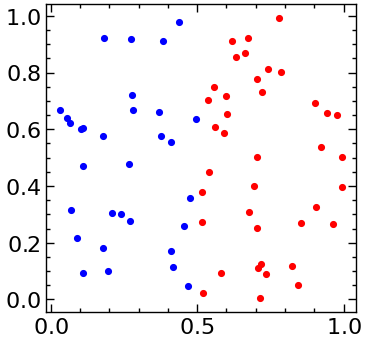

In [6]:
# Notice that one must to take the tensor out of the graphic card to allow the plotting of data
plt.figure(figsize=(4,4))
plt.scatter(r[0][right_xbool].cpu(), r[1][right_xbool].cpu(), c="r", s=17)
plt.scatter(r[0][left_xbool].cpu(),  r[1][left_xbool].cpu(), c="b", s=17);
# The idea is to have the blue particles colliding the red particles and vice versa at 500 m/s

In [7]:
v = torch.zeros((2,n_particles)).to(device)
v[0][right_xbool] = -500
v[0][left_xbool] = 500

### Distance between pairs

The total distance is thus

$$
    d_{ij} = \sqrt{\Delta x_{ij}^2 + \Delta y_{ij}^2}
$$

In [8]:
ID_pairs = torch.combinations(id_particles,2).to(device) # ID pairs
x_pairs  = torch.combinations(r[0],2).to(device)         # x-distance pairs
y_pairs  = torch.combinations(r[1],2).to(device)         # y-distance pairs
dx_pairs = torch.diff(x_pairs, axis=1).ravel()           # Δx_ij | .ravel() to get a 1D-array
dy_pairs = torch.diff(y_pairs, axis=1).ravel()           # Δy_ij | .ravel() to get a 1D-array
d_ij = torch.sqrt( dx_pairs*dx_pairs + dy_pairs*dy_pairs ) # Euclidean distance between particles

### Elastic Collisions

At each iteration, the total distance is checked such that it sets a new velocity when it takes a lower value than the diamater of the particle. For that, one considers the following elastic collision

$$
        \vec{v}^{new}_i = \vec{v}_i - \frac{(\vec{v}_i - \vec{v}_j)\cdot(\vec{r}_i - \vec{r}_j)}{\mid\vec{r}_i - \vec{r}_j\mid^2} (\vec{r}_i - \vec{r}_j),
$$

here, $i=\{1,2\}$ is the indexing of particles collinding.

In [9]:
# Colliding particles:
id_colliding_pairs = ID_pairs[d_ij <= 2*radius]

tensor([[ 0, 36],
        [ 1, 22],
        [ 1, 32],
        [ 2, 16],
        [ 2, 30],
        [ 3, 20],
        [ 3, 26],
        [ 3, 62],
        [ 4, 52],
        [ 4, 60],
        [ 5, 25],
        [ 5, 62],
        [ 5, 66],
        [ 6, 12],
        [ 6, 31],
        [ 6, 43],
        [ 6, 50],
        [ 6, 57],
        [ 7, 35],
        [ 7, 38],
        [ 7, 51],
        [ 7, 58],
        [ 7, 69],
        [ 8, 39],
        [ 8, 68],
        [ 9, 45],
        [ 9, 63],
        [11, 24],
        [11, 53],
        [11, 54],
        [11, 55],
        [11, 64],
        [12, 31],
        [12, 50],
        [13, 39],
        [14, 19],
        [15, 41],
        [15, 43],
        [15, 57],
        [16, 17],
        [17, 19],
        [18, 20],
        [18, 26],
        [18, 33],
        [18, 59],
        [20, 26],
        [20, 59],
        [20, 62],
        [21, 28],
        [21, 30],
        [21, 46],
        [21, 56],
        [22, 32],
        [23, 36],
        [23, 42],
        [2

In [10]:
# Colliding particles: velocities and position

v1 = v[:,id_colliding_pairs[:,0]]
v2 = v[:,id_colliding_pairs[:,1]]
r1 = r[:,id_colliding_pairs[:,0]]
r2 = r[:,id_colliding_pairs[:,1]]

In [11]:
# New velocities
v1_new = v1 - ( torch.sum( (v1-v2)*(r1-r2),axis=0 )/torch.sum((r1-r2)**2, axis=0) ) * (r1-r2)
v2_new = v2 - ( torch.sum( (v2-v1)*(r2-r1),axis=0 )/torch.sum((r2-r1)**2, axis=0) ) * (r2-r1)

## Compilling ideas to motion

In [12]:
def get_initial_position(n_particles, seed=71):
    """
    Returns random (x,y) positions for a total of n_particles with ID. 
    """
    torch.manual_seed(seed)
    r = torch.rand((2, n_particles)).to(device) # x, y positions
    right_xbool = r[0] > 0.5; left_xbool = r[0] <= 0.5
    return r, right_xbool, left_xbool

def get_initial_velocities(n_particles, ivelocity):
    """
    Returns initital velocities for colliding particles: left vs right
    ivelocities (2D tuple of ints): (vx_0, vy_0) [m/s]
    """
    # discern the particles that start on the left and right
    r, right_xbool, left_xbool = get_initial_position(n_particles)
    # Velocity Initialization
    v = torch.zeros((2,n_particles)).to(device)
    v[0][right_xbool] = -ivelocity
    v[0][left_xbool] = ivelocity
    return v

def get_idx_colliding_particles(radius, r):
    """
    This function assigns an unique ID to each particle and 
    determines distance between particles to obtain the colliding ones. 
    """
    # ID of individual particles
    id_particles = torch.arange(n_particles)
    ID_pairs = torch.combinations(id_particles,2).to(device) # ID pairs
    dx_pairs = torch.diff(torch.combinations(r[0],2).to(device)).squeeze() # Δx_ij 
    dy_pairs = torch.diff(torch.combinations(r[1],2).to(device)).squeeze() # Δy_ij 
    d_ij = torch.sqrt( dx_pairs**2 + dy_pairs**2 ) # Euclidean distance between particles
    id_colliding_pairs = ID_pairs[d_ij <= 2*radius]
    return id_colliding_pairs

def update_velocities(radius, r, v):
    """
    Updating for colliding particles
    """
    id_colliding_pairs = get_idx_colliding_particles(radius, r)
    v1 = v[:,id_colliding_pairs[:,0]]
    v2 = v[:,id_colliding_pairs[:,1]]
    r1 = r[:,id_colliding_pairs[:,0]]
    r2 = r[:,id_colliding_pairs[:,1]]
    
    # New velocities
    v1_new = v1 - ( torch.sum( (v1-v2)*(r1-r2),axis=0 )/torch.sum((r1-r2)**2, axis=0) ) * (r1-r2)
    v2_new = v2 - ( torch.sum( (v2-v1)*(r2-r1),axis=0 )/torch.sum((r2-r1)**2, axis=0) ) * (r2-r1)

    return v1_new, v2_new


def particles_motion(n_particles, radius, ivelocity, ts, dt):
    """
    Returns the updated position and velocity considering elastic collision.
    
    This function is used to create all the images needed for the simulation.
    """
    
    r = get_initial_position(n_particles)[0]
    v = get_initial_velocities(n_particles, ivelocity)
    
    # 3D vector: two-spatial, one time
    R = torch.zeros((ts, r.shape[0], r.shape[1])).to(device)
    V = torch.zeros((ts, v.shape[0], v.shape[1])).to(device)
    # Set Initial State
    R[0] = r
    V[0] = v
    for time in range(1,ts):
        id_cprs = get_idx_colliding_particles(radius, r)
        v[:,id_cprs[:,0]], v[:,id_cprs[:,1]] = update_velocities(radius, r, v)

        # Confine particles inside a box
        v[0, r[0]>1] = -torch.abs(v[0, r[0]>1])
        v[0, r[0]<0] =  torch.abs(v[0, r[0]<0])
        v[1, r[1]>1] = -torch.abs(v[1, r[1]>1])
        v[1, r[1]<0] =  torch.abs(v[1, r[1]<0])
        
        r = r + v*dt
        R[time] = r
        V[time] = v
        
    return R, V

In [17]:
n_particles = 70
radius = 0.03     # [m]
ivelocities = 500 # [m/s]

_, right_xbool, left_xbool = get_initial_position(n_particles)

In [18]:
R, V = particles_motion(n_particles, radius, ivelocities, ts=1000, dt=0.000005)

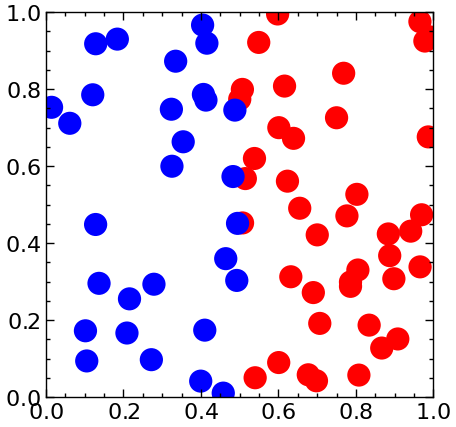

In [19]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
xred, yred   = R[0][0][right_xbool], R[0][1][right_xbool]
xblue, yblue = R[0][0][left_xbool],R[0][1][left_xbool]
circles_red  = [plt.Circle((xi, yi), radius=radius, linewidth=0) for xi,yi in zip(xred,yred)]
circles_blue = [plt.Circle((xi, yi), radius=radius, linewidth=0) for xi,yi in zip(xblue,yblue)]
cred = matplotlib.collections.PatchCollection(circles_red, facecolors='red')
cblue = matplotlib.collections.PatchCollection(circles_blue, facecolors='blue')
ax.add_collection(cred)
ax.add_collection(cblue)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
plt.show()

# IMPORTANT OPTIMIZATION ON ANIMATION: `blit=True`


This does not redo data in the image that does not change, making the animation faster. 

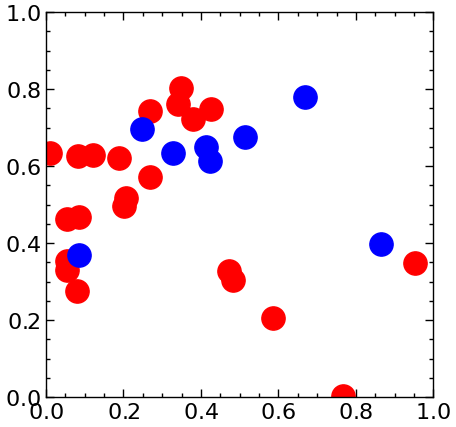

In [16]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.clear()
vmin = 0
vmax = 1
ax.set_xlim(0,1)
ax.set_ylim(0,1)
markersize = 2 * radius * ax.get_window_extent().width  / (vmax-vmin) * 72./fig.dpi
red, = ax.plot([], [], 'o', color='red', markersize=markersize)
blue, = ax.plot([], [], 'o', color='blue', markersize=markersize)

def animate(i):
    xred, yred = R[i][0][right_xbool].cpu(), R[i][1][right_xbool].cpu()
    xblue, yblue = R[i][0][left_xbool].cpu(),R[i][1][left_xbool].cpu()
    red.set_data(xred, yred)
    blue.set_data(xblue, yblue)
    return red, blue

writer = animation.FFMpegWriter(fps=30)
ani = animation.FuncAnimation(fig, animate, frames=500, interval=50, blit=True)
ani.save('GIFs/withGPU_30_particles_test.mp4',writer=writer, dpi=100)

Notice the overlap of particles is because of the initialization and the radius being too big. This can be fixed by either setting a constraint in random initialization or making the radius too small; but, it is not a big of a deal.

### Now with Boltzmann Distribution and more particles

In [21]:
n_particles = 500
radius = 0.0005     # [m]
ivelocities = 500 # [m/s]

_, right_xbool, left_xbool = get_initial_position(n_particles)
R, V = particles_motion(n_particles, radius, ivelocities, ts=1500, dt=0.000008)
# began 19:30 -- 19:55 (radius = 0.01, npart = 5000)
# began 20:06 -- 20:32 (radius = 0.0005, npart = 5000)

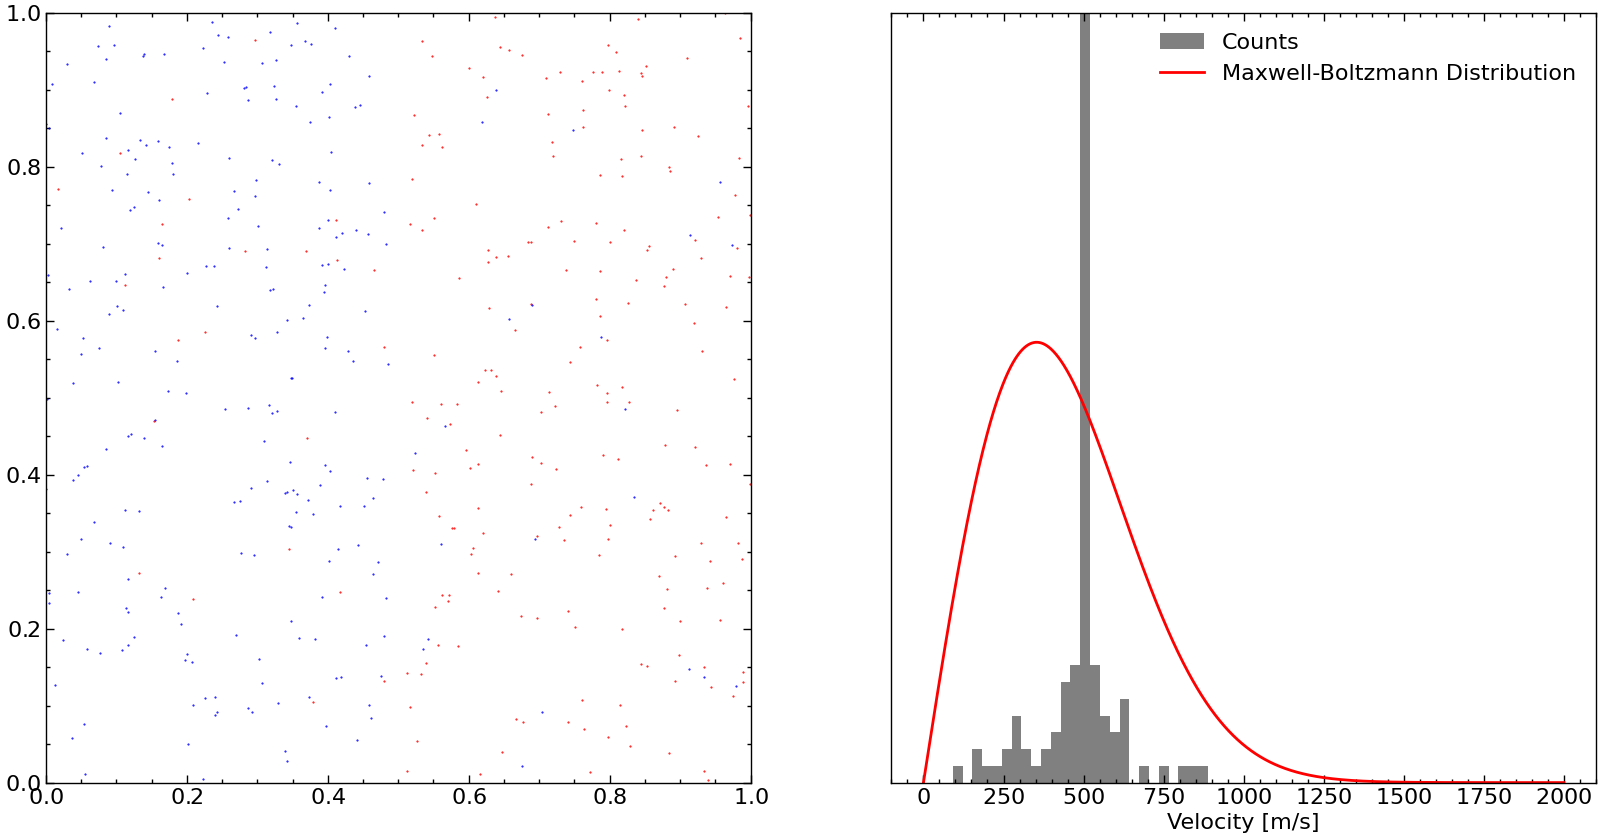

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(20,10))
bins = np.linspace(0,1500,50)
axes[0].clear()

v = np.linspace(0, 2000, 1000)
factor = 2/ivelocities**2
fv = factor*v*np.exp(-factor*v**2 / 2)

vmin = 0
vmax = 1

axes[0].set_xlim(0,1)
axes[0].set_ylim(0,1)

markersize = 2 * radius * axes[0].get_window_extent().width  / (vmax-vmin) * 72./fig.dpi
red, = axes[0].plot([], [], 'o', color='red', markersize=markersize)
blue, = axes[0].plot([], [], 'o', color='blue', markersize=markersize)
n, bins, patches = axes[1].hist(torch.sqrt(torch.sum(V[0]**2, axis=0)).cpu(),
                                bins=bins, density=True, color="gray", label="Counts")
axes[1].plot(v,fv, color="red", label = "Maxwell-Boltzmann Distribution")
axes[1].set_ylim(top=0.003)
axes[1].set_xlabel('Velocity [m/s]')
axes[1].set_yticks([])
axes[1].legend()

def animate(i):
    xred, yred = R[i][0][right_xbool].cpu(), R[i][1][right_xbool].cpu()
    xblue, yblue = R[i][0][left_xbool].cpu(),R[i][1][left_xbool].cpu()
    red.set_data(xred, yred)
    blue.set_data(xblue, yblue)
    hist, _ = np.histogram(torch.sqrt(torch.sum(V[i]**2, axis=0)).cpu(),
                           bins=bins, density=True)
    for i, patch in enumerate(patches):
        patch.set_height(hist[i])
    return red, blue

writer = animation.FFMpegWriter(fps=30)
ani = animation.FuncAnimation(fig, animate, frames=500, interval=50, blit=True)
ani.save(f'GIFs/withGPU_{n_particles}_smaller__particles.mp4',writer=writer,dpi=100)